# Testing the MLE Fitting Functions

The Hawkes module implements the multivariate Hawkes marked point process. We assume an exponential decay function is used to improve the numerical computation of the intensity function [Liniger, 2012].

Generating artificial points to be used as data for fit (see simulation notebook):

In [1]:
import hawkes
import markDistributions as md
import numpy as np
import scipy.optimize as op
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pylab import rcParams

%matplotlib inline
np.set_printoptions(precision=3, suppress=True)
rcParams['figure.figsize'] = 16, 5

d=2
numPoints=15000+200

eta=[0.021,0.029]
Q=[0.61,0.16,0.6,0.06]
alpha=[0.005]*d
mu=[3.6,4.2]
rho=[5.6,7.2]
alph=[0.47,1.1]
beta=[0.22,0.0]

mdParam1=[alph[0],beta[0]]
mdParam2=[alph[1],beta[1]]

sparam = []
sparam.extend(eta)
sparam.extend(Q)
sparam.extend(alpha)
sparam.extend(mdParam1)
sparam.extend(mdParam2)

markparam = [[mu[0],rho[0]],[mu[1],rho[1]]]

sim = hawkes.Hawkes(d=d)
sim.setParam(sparam)
sim.setMarkDistParam(markparam)

t,j,x = sim.simulate(numPoints)[0]

Setup a seperate Hawkes marked point process and set the mark distribution parameters:

In [2]:
h = hawkes.Hawkes(d=d)
h.setMarkDistParam(markparam)

Fit the new Hawkes process to the simulated data using L-BFGS-B to get good initialization:

In [3]:
result = h.MLE(t,j,x,method='L-BFGS-B')

arr = result["x"]

print("""eta:
        {0} - estimated
        {1} - true\n""".format(arr[:2],np.asarray(eta)))
print("""Q:
        {0} - estimated
        {1} - true\n""".format(arr[2:6],np.asarray(Q)))
print("""alpha:
        {0} - estimated
        {1} - true\n""".format(arr[6:8],np.asarray(alpha)))
print("""alph:
        {0} - estimated
        {1} - true\n""".format(arr[8:10],np.asarray(alph)))
print("""beta:
        {0} - estimated
        {1} - true\n""".format(arr[10:12],np.asarray(beta)))

print("""Spr(Q) of estimated model: {0}""".format(h.ibParam.getSpectralRadius()))

eta:
        [ 0.033  0.032] - estimated
        [ 0.021  0.029] - true

Q:
        [ 0.552  0.095  0.579  0.073] - estimated
        [ 0.61  0.16  0.6   0.06] - true

alpha:
        [ 0.006  0.004] - estimated
        [ 0.005  0.005] - true

alph:
        [ 9.05   0.342] - estimated
        [ 0.47  1.1 ] - true

beta:
        [ 0.349  9.819] - estimated
        [ 0.22  0.  ] - true

Spr(Q) of estimated model: 0.647363624875


Obtaining the residual process:

In [4]:
j_, t_, x_, tau, xi = h.Residual(t,j,x)

If the estimated Hawkes model is correct, the residual process should be $d$ independent Poisson processes. Hence, we should see the residual events being declustered compared to the original, by plotting the duration between the events.

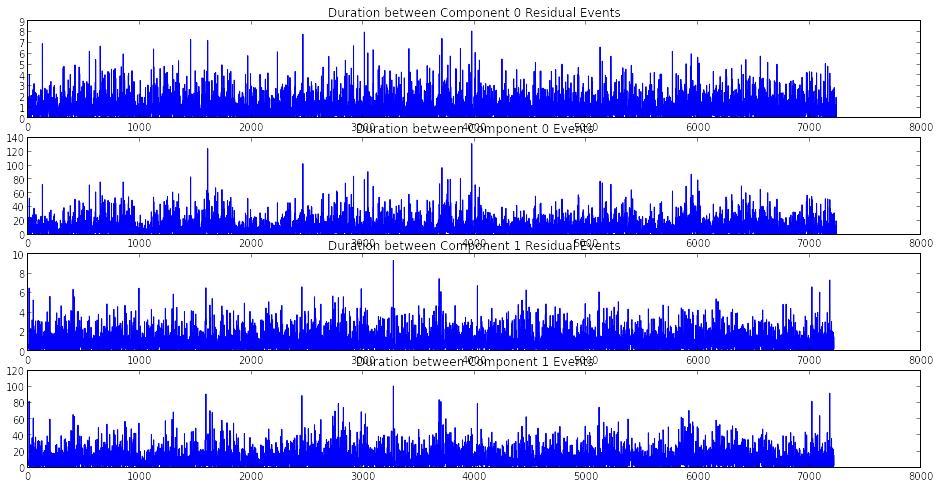

In [5]:
s0 = t_[j_==0]
s1 = t_[j_==1]
intervals0 = s0[1:] - s0[:-1]
intervals1 = s1[1:] - s1[:-1]

r0 = tau[j_==0]
r1 = tau[j_==1]
intervalr0 = r0[1:] - r0[:-1]
intervalr1 = r1[1:] - r1[:-1]

rcParams['figure.figsize'] = 16, 8
f, axarr = plt.subplots(4)
axarr[0].plot(np.arange(len(intervalr0)), intervalr0)
axarr[0].set_title('Duration between Component 0 Residual Events')
axarr[1].plot(np.arange(len(intervals0)), intervals0)
axarr[1].set_title('Duration between Component 0 Events')
axarr[2].plot(np.arange(len(intervalr1)), intervalr1)
axarr[2].set_title('Duration between Component 1 Residual Events')
axarr[3].plot(np.arange(len(intervals1)), intervals1)
axarr[3].set_title('Duration between Component 1 Events')
plt.show()

The duration between the residual events should also be exponentially distributed, since the residual processes should be Poisson processes with unit intensity:

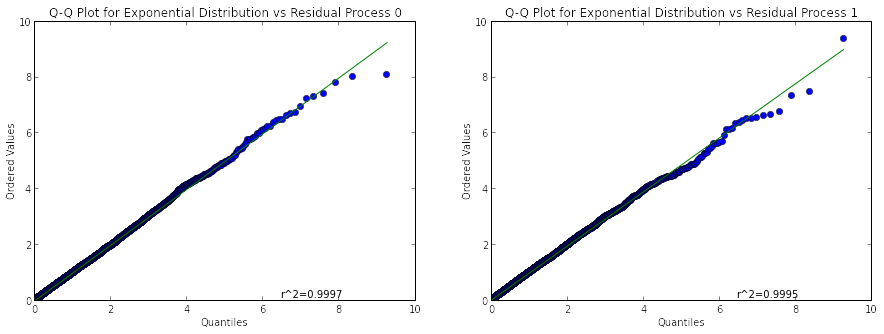

In [6]:
m0 = intervalr0
m1 = intervalr1

rcParams['figure.figsize'] = 15, 5
fig = plt.figure()
ax1 = plt.subplot(121)
stats.probplot(m0, dist="expon", plot=plt)
ax1.set_title("Q-Q Plot for Exponential Distribution vs Residual Process 0")
ax2 = plt.subplot(122)
stats.probplot(m1, dist="expon", plot=plt)
ax2.set_title("Q-Q Plot for Exponential Distribution vs Residual Process 1")
plt.show()